## Load required modules

In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
TORCH_MAX = torch.finfo(torch.float64).max

from deep_continuation.dataset import get_file_paths, DATAPATH



/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the dataloaders from the csv files

Note that the data input is standardized.

In [2]:
class ContinuationData(torch.utils.data.Dataset):
    def __init__(self, noise=0.0, standardize=True, avg=None, std=None,
        # dataset file info
        path=str(os.path.join(DATAPATH, "")),
        name="B1",
        size=100000,
        seed=55555,
        Nwn=128, 
        Nw=512, 
        beta=30, 
        wmax=20, 
        rescale=False,
        spurious=False,
    ):
        pi_path, sigma_path, _ = get_file_paths(
            path, name, size, seed, Nwn, beta, Nw, wmax, rescale, spurious,
        )
        self.x_data = np.load(pi_path)
        self.y_data = np.load(sigma_path)

        self.noise = noise
        self.standardize = standardize
        if avg and std:
            self.avg=avg
            self.sdt=std
        else:
            self.avg = self.x_data.mean(axis=-2)
            self.std = self.x_data.std(axis=-2)
        
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = self.x_data[index]
        x += np.random.normal(0,1, size=x.shape)*self.noise
        if self.standardize:
            x = (x - self.avg)/self.std

        y = self.y_data[index]
        return x, y

print("loading data...")
valid_set = ContinuationData(name='B1', size=10000, seed=555)
train_set = ContinuationData(name='B1', size=100000, seed=55555)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=523, 
    shuffle=True, 
    drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, 
    batch_size=523, 
    shuffle=False, 
    drop_last=True,
)
print(" done")

loading data...
 done


## Define the Model and initialize weights

In [3]:
class MLP(nn.Module):
    def __init__(self, layers=[128, 952, 1343, 1673, 1722, 512]):
        super(MLP, self).__init__()
        self.epoch = 0
        
        self.layers = nn.ModuleList()
        sizeA = layers[0]
        for sizeB in layers[1:]:
            self.layers.append(nn.Linear(sizeA, sizeB))
            self.layers.append(nn.ReLU())
            sizeA = sizeB

        self.layers.append(nn.Linear(sizeA, layers[-1]))
        self.layers.append(nn.Softmax(dim=-1))
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


def initialize_weights(module, gain=1):
    if type(module) == nn.Linear:
        torch.nn.init.xavier_uniform_(module.weight, gain=gain)
        torch.nn.init.zeros_(module.bias)

model = MLP().to(device)
model.apply(initialize_weights)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=952, bias=True)
    (1): ReLU()
    (2): Linear(in_features=952, out_features=1343, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1343, out_features=1673, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1673, out_features=1722, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1722, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Softmax(dim=-1)
  )
)

## Define the loss function, optimizer, and learning rate scheduler

In [4]:
loss_function = nn.L1Loss()  
mse_function = nn.MSELoss()

lr = 8e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.216, 
    patience=5,
    verbose=True,
    min_lr=1e-10
)

## Training and validation loop
Use a learning rate warmup, early stopping and plot a spectrum each epoch 

 epoch 1
   train loss: 0.001239527, mse: 0.001075967
   valid loss: 0.000725828, mse:0.000036584


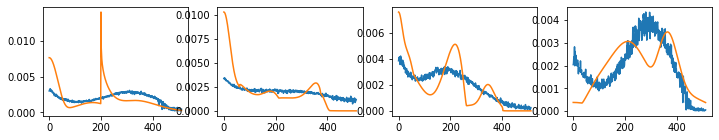

 epoch 2
   train loss: 0.000583310, mse: 0.000256715
   valid loss: 0.000526271, mse:0.000021013


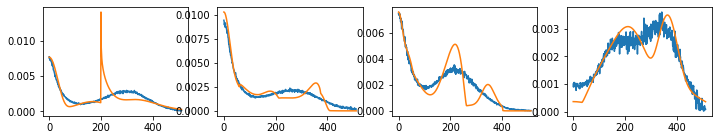

 epoch 3
   train loss: 0.000500271, mse: 0.000199821
   valid loss: 0.000472966, mse:0.000017950


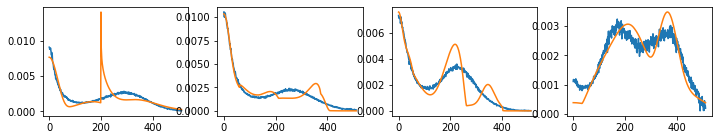

 epoch 4
   train loss: 0.000462603, mse: 0.000179047
   valid loss: 0.000455424, mse:0.000017120


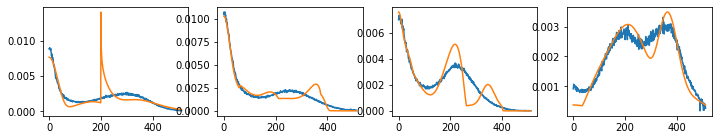

 epoch 5
   train loss: 0.000445972, mse: 0.000171579
   valid loss: 0.000441505, mse:0.000016421


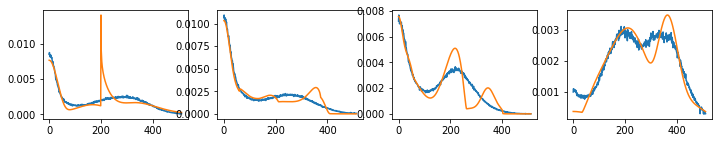

 epoch 6
   train loss: 0.000433329, mse: 0.000166563
   valid loss: 0.000439445, mse:0.000016226


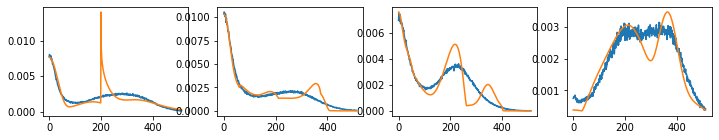

 epoch 7
   train loss: 0.000423277, mse: 0.000162239
   valid loss: 0.000426005, mse:0.000015843


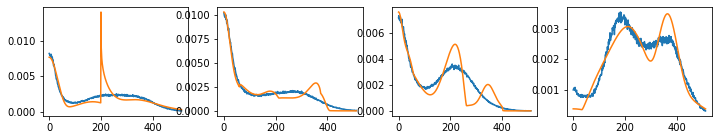

 epoch 8
   train loss: 0.000412641, mse: 0.000158060
   valid loss: 0.000410280, mse:0.000015184


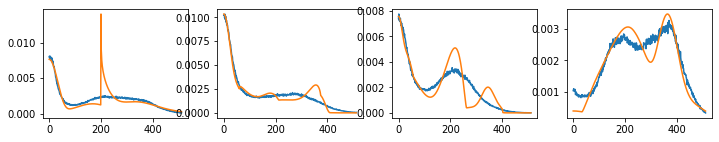

 epoch 9
   train loss: 0.000404542, mse: 0.000154414
   valid loss: 0.000404769, mse:0.000015000


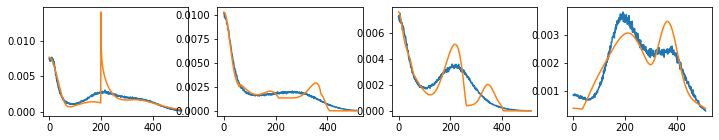

 epoch 10
   train loss: 0.000396712, mse: 0.000150977
   valid loss: 0.000394083, mse:0.000014368


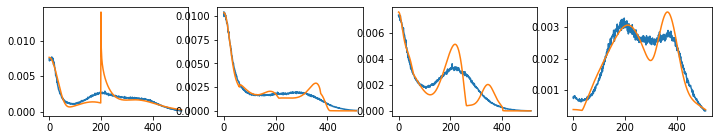

 epoch 11
   train loss: 0.000388878, mse: 0.000146965
   valid loss: 0.000384308, mse:0.000014229


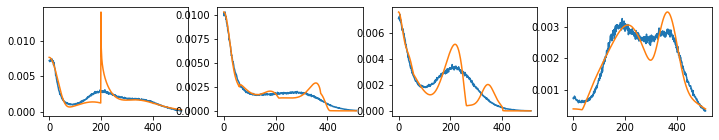

 epoch 12
   train loss: 0.000383480, mse: 0.000145329
   valid loss: 0.000379469, mse:0.000013986


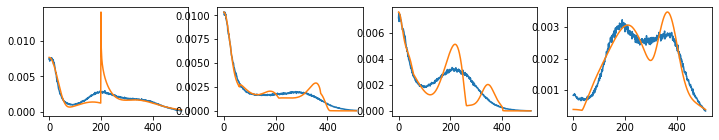

 epoch 13
   train loss: 0.000374192, mse: 0.000141892
   valid loss: 0.000373869, mse:0.000013773


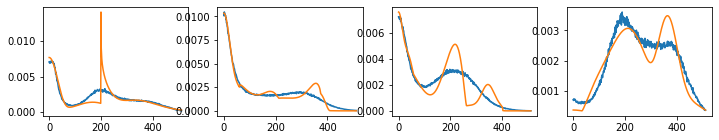

 epoch 14
   train loss: 0.000369793, mse: 0.000140055
   valid loss: 0.000367560, mse:0.000013430


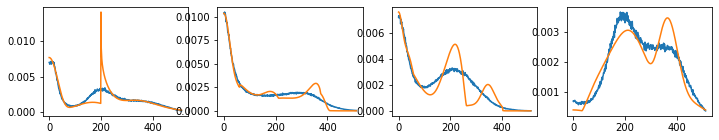

 epoch 15
   train loss: 0.000365228, mse: 0.000138185
   valid loss: 0.000357012, mse:0.000013090


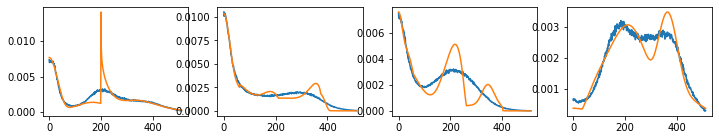

 epoch 16
   train loss: 0.000360360, mse: 0.000136570
   valid loss: 0.000355864, mse:0.000012935


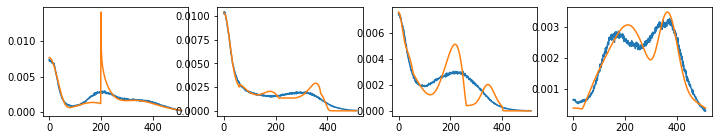

 epoch 17
   train loss: 0.000355526, mse: 0.000134750
   valid loss: 0.000357050, mse:0.000012907


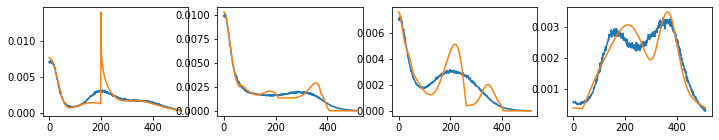

 epoch 18
   train loss: 0.000352912, mse: 0.000133616
   valid loss: 0.000351286, mse:0.000012984


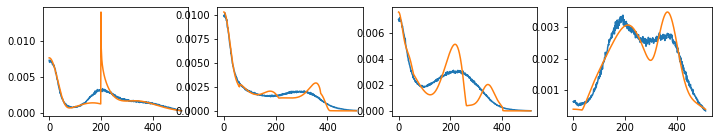

 epoch 19
   train loss: 0.000349313, mse: 0.000132259
   valid loss: 0.000348823, mse:0.000012987


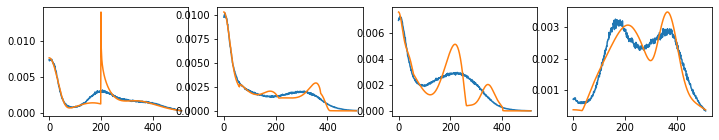

 epoch 20
   train loss: 0.000346332, mse: 0.000131193
   valid loss: 0.000347455, mse:0.000012619


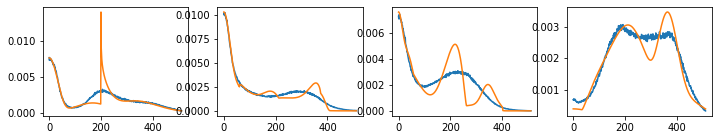

 epoch 21
   train loss: 0.000344659, mse: 0.000130576
   valid loss: 0.000339096, mse:0.000012392


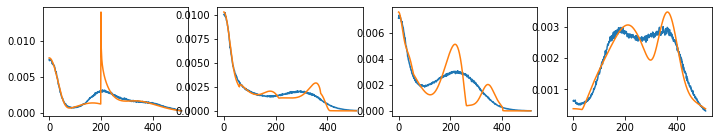

 epoch 22
   train loss: 0.000341538, mse: 0.000129283
   valid loss: 0.000349061, mse:0.000012460


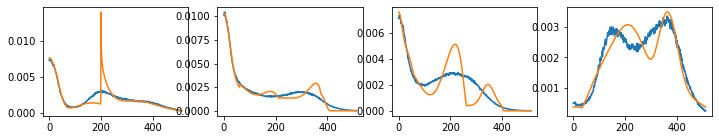

 epoch 23
   train loss: 0.000339322, mse: 0.000128529
   valid loss: 0.000338750, mse:0.000012190


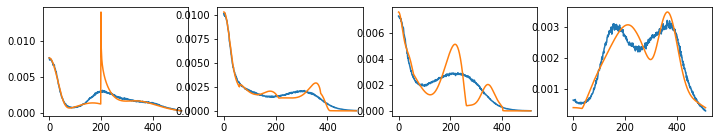

 epoch 24
   train loss: 0.000335259, mse: 0.000127047
   valid loss: 0.000337866, mse:0.000012394


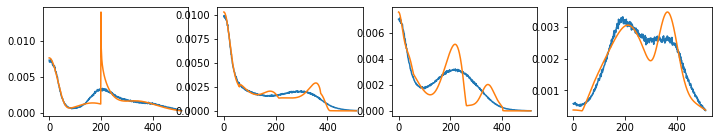

 epoch 25
   train loss: 0.000332721, mse: 0.000126193
   valid loss: 0.000333002, mse:0.000012055


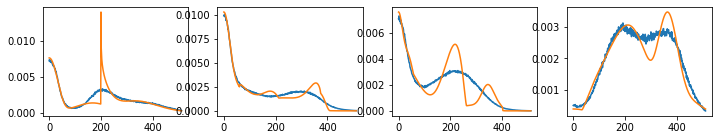

 epoch 26
   train loss: 0.000330716, mse: 0.000125283
   valid loss: 0.000330273, mse:0.000011920


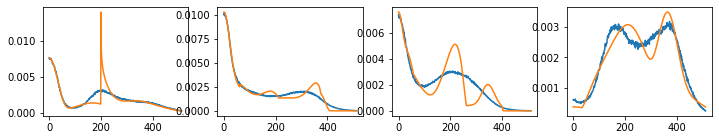

 epoch 27
   train loss: 0.000327796, mse: 0.000124315
   valid loss: 0.000326030, mse:0.000011837


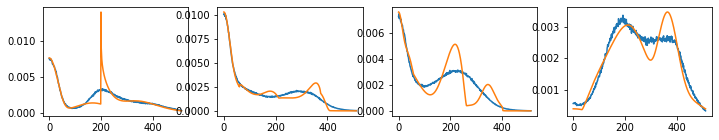

 epoch 28
   train loss: 0.000328679, mse: 0.000124455
   valid loss: 0.000325164, mse:0.000011782


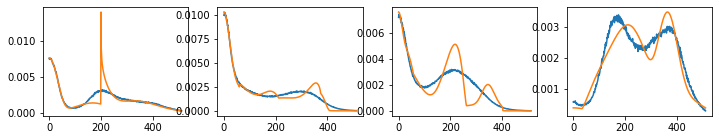

 epoch 29
   train loss: 0.000326442, mse: 0.000123601
   valid loss: 0.000325519, mse:0.000011727


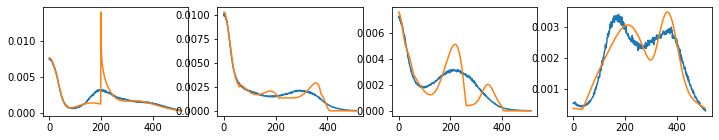

 epoch 30
   train loss: 0.000324477, mse: 0.000122977
   valid loss: 0.000335030, mse:0.000012265


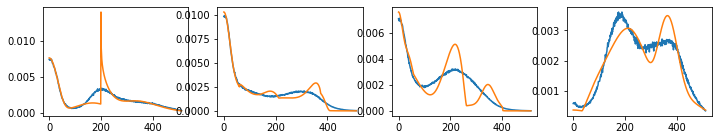

 epoch 31
   train loss: 0.000323831, mse: 0.000122659
   valid loss: 0.000322611, mse:0.000011805


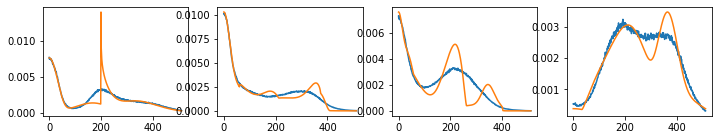

 epoch 32
   train loss: 0.000322991, mse: 0.000120724
   valid loss: 0.000320645, mse:0.000011594


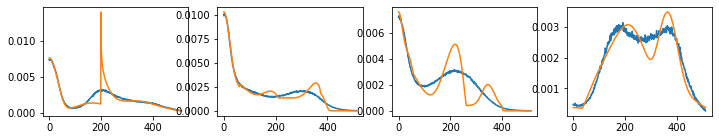

 epoch 33
   train loss: 0.000319737, mse: 0.000121120
   valid loss: 0.000322710, mse:0.000011644


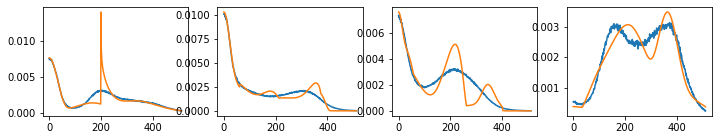

 epoch 34
   train loss: 0.000316429, mse: 0.000120035
   valid loss: 0.000315676, mse:0.000011480


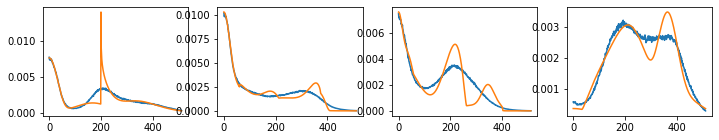

 epoch 35
   train loss: 0.000319067, mse: 0.000120849
   valid loss: 0.000313856, mse:0.000011520


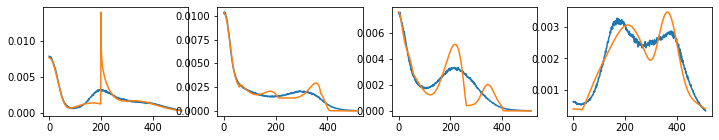

 epoch 36
   train loss: 0.000315118, mse: 0.000119392
   valid loss: 0.000320721, mse:0.000011673


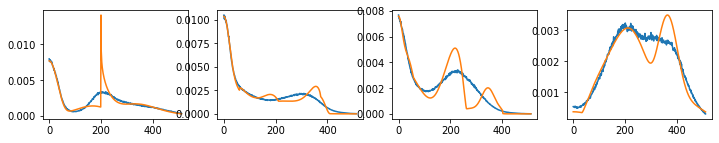

 epoch 37
   train loss: 0.000313100, mse: 0.000118707
   valid loss: 0.000316036, mse:0.000011487


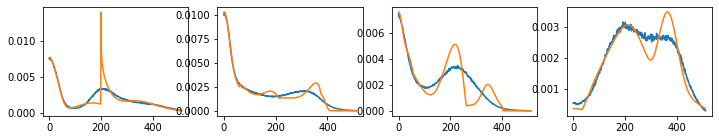

 epoch 38
   train loss: 0.000312353, mse: 0.000118321
   valid loss: 0.000324543, mse:0.000011581


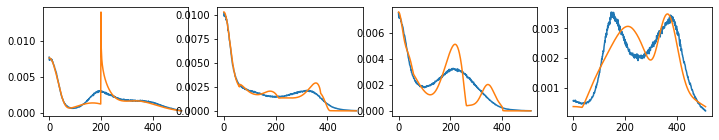

 epoch 39
   train loss: 0.000311633, mse: 0.000117997
   valid loss: 0.000317516, mse:0.000011457


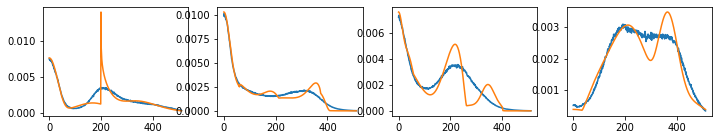

 epoch 40
   train loss: 0.000312072, mse: 0.000118204
   valid loss: 0.000308722, mse:0.000011223


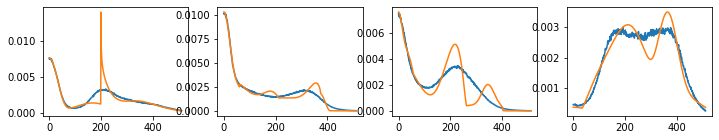

 epoch 41
   train loss: 0.000307874, mse: 0.000116542
   valid loss: 0.000307972, mse:0.000011130


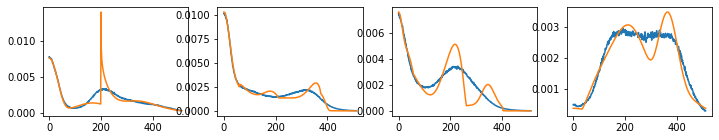

 epoch 42
   train loss: 0.000308625, mse: 0.000116947
   valid loss: 0.000316935, mse:0.000011403


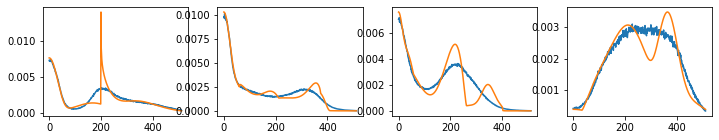

 epoch 43
   train loss: 0.000307131, mse: 0.000116315
   valid loss: 0.000307217, mse:0.000011142


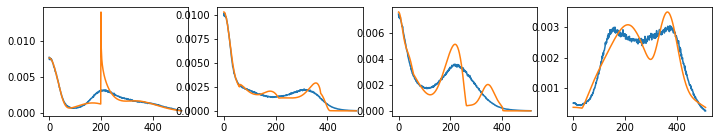

 epoch 44
   train loss: 0.000305432, mse: 0.000115725
   valid loss: 0.000306874, mse:0.000011048


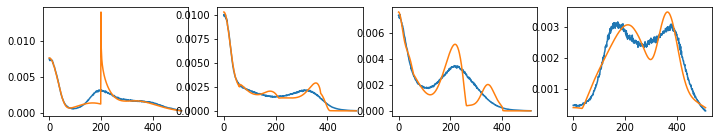

 epoch 45
   train loss: 0.000305450, mse: 0.000115709
   valid loss: 0.000308810, mse:0.000011165


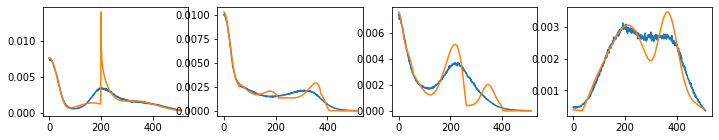

 epoch 46
   train loss: 0.000302807, mse: 0.000114860
   valid loss: 0.000308930, mse:0.000011131


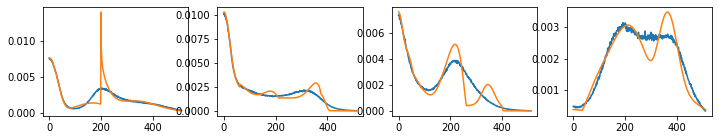

 epoch 47
   train loss: 0.000305720, mse: 0.000115599
   valid loss: 0.000310968, mse:0.000011134


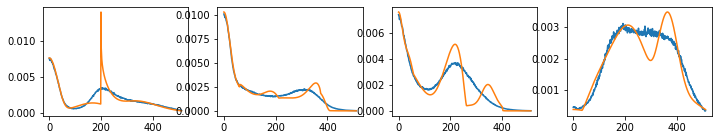

 epoch 48
   train loss: 0.000301368, mse: 0.000114260
   valid loss: 0.000317900, mse:0.000011257


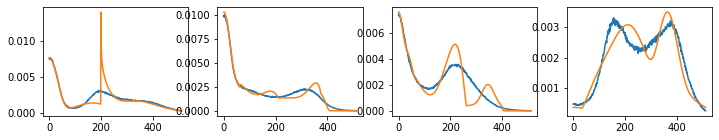

 epoch 49
   train loss: 0.000301820, mse: 0.000114414
   valid loss: 0.000305797, mse:0.000010955


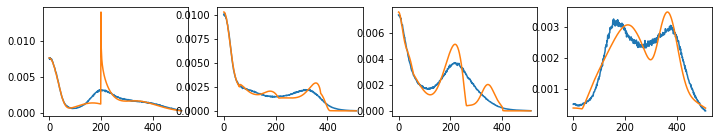

 epoch 50
   train loss: 0.000300312, mse: 0.000113872
   valid loss: 0.000302443, mse:0.000010900


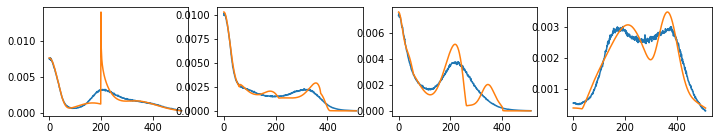

 epoch 51
   train loss: 0.000300802, mse: 0.000114127
   valid loss: 0.000315405, mse:0.000011198


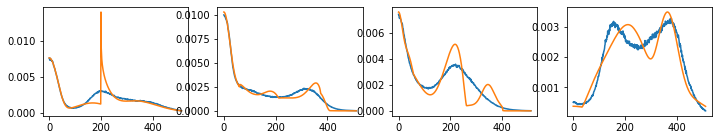

 epoch 52
   train loss: 0.000298223, mse: 0.000113090
   valid loss: 0.000304757, mse:0.000010934


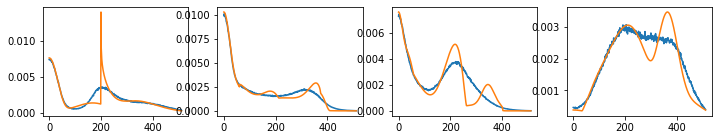

 epoch 53
   train loss: 0.000298557, mse: 0.000113204
   valid loss: 0.000308392, mse:0.000010978


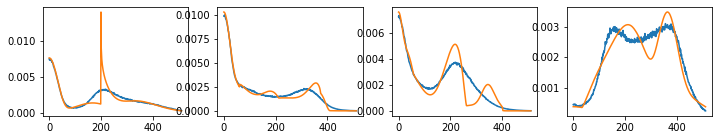

 epoch 54
   train loss: 0.000299276, mse: 0.000113124
   valid loss: 0.000311221, mse:0.000011227


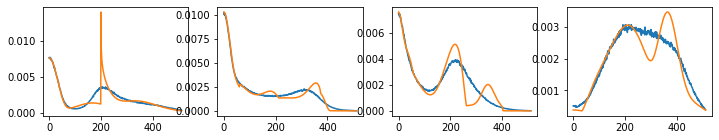

 epoch 55
   train loss: 0.000296074, mse: 0.000112330
   valid loss: 0.000297474, mse:0.000010824


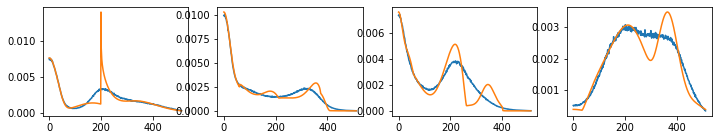

 epoch 56
   train loss: 0.000296892, mse: 0.000112455
   valid loss: 0.000298953, mse:0.000010766


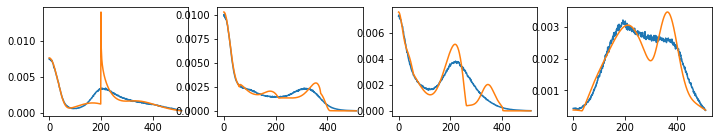

 epoch 57
   train loss: 0.000297089, mse: 0.000112655
   valid loss: 0.000300823, mse:0.000010856


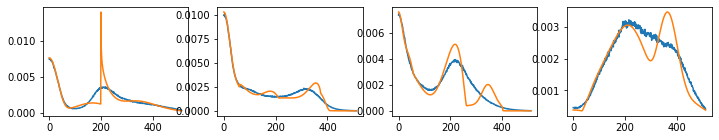

 epoch 58
   train loss: 0.000297093, mse: 0.000112545
   valid loss: 0.000303666, mse:0.000010851


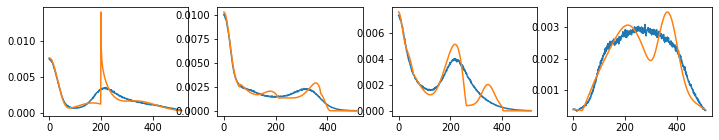

 epoch 59
   train loss: 0.000294412, mse: 0.000111715
   valid loss: 0.000299099, mse:0.000010707


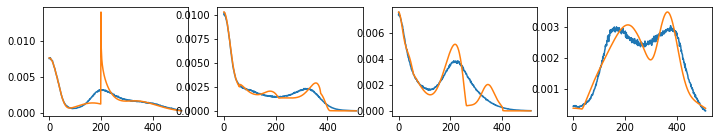

 epoch 60
   train loss: 0.000294848, mse: 0.000111665
   valid loss: 0.000296913, mse:0.000010669


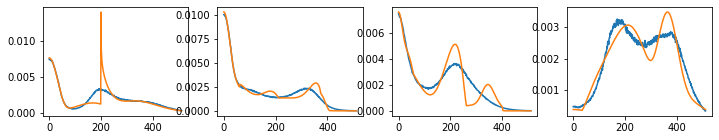

 epoch 61
   train loss: 0.000292770, mse: 0.000111223
   valid loss: 0.000295506, mse:0.000010638


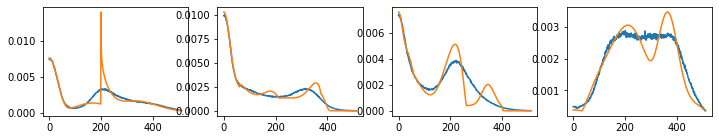

 epoch 62
   train loss: 0.000292012, mse: 0.000110674
   valid loss: 0.000299006, mse:0.000010663


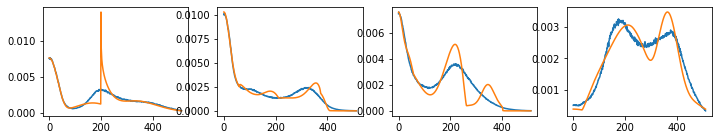

 epoch 63
   train loss: 0.000292892, mse: 0.000110992
   valid loss: 0.000293137, mse:0.000010612


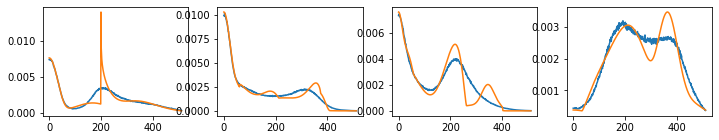

 epoch 64
   train loss: 0.000291434, mse: 0.000110681
   valid loss: 0.000312291, mse:0.000011267


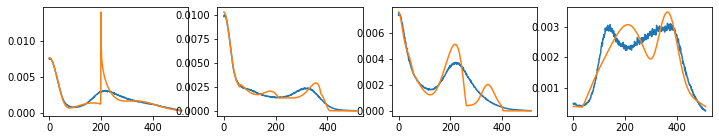

 epoch 65
   train loss: 0.000291737, mse: 0.000110515
   valid loss: 0.000298232, mse:0.000010713


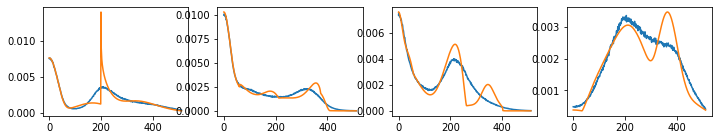

 epoch 66
   train loss: 0.000293689, mse: 0.000111260
   valid loss: 0.000295891, mse:0.000010833


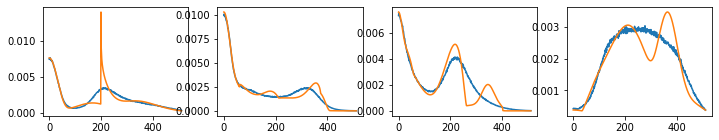

 epoch 67
   train loss: 0.000291793, mse: 0.000110538
   valid loss: 0.000291944, mse:0.000010487


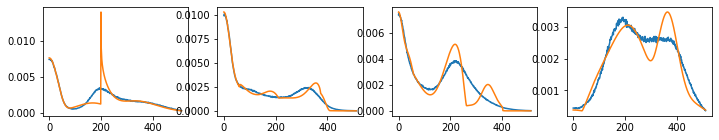

 epoch 68
   train loss: 0.000289030, mse: 0.000109698
   valid loss: 0.000288932, mse:0.000010551


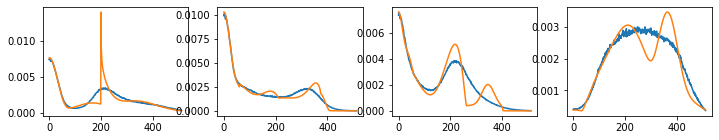

 epoch 69
   train loss: 0.000287930, mse: 0.000109219
   valid loss: 0.000292525, mse:0.000010534


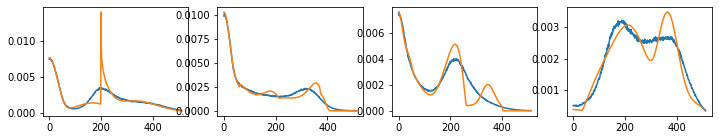

 epoch 70
   train loss: 0.000288893, mse: 0.000109585
   valid loss: 0.000301071, mse:0.000010739


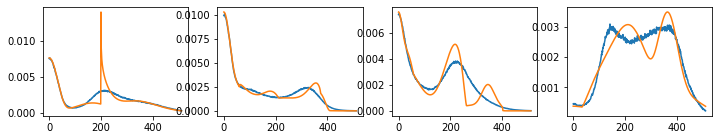

 epoch 71
   train loss: 0.000288599, mse: 0.000109415
   valid loss: 0.000291585, mse:0.000010511


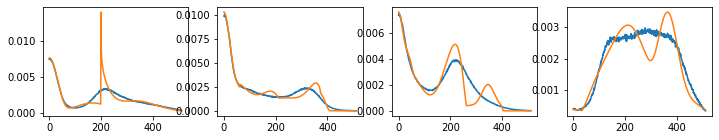

 epoch 72
   train loss: 0.000288419, mse: 0.000109280
   valid loss: 0.000288110, mse:0.000010432


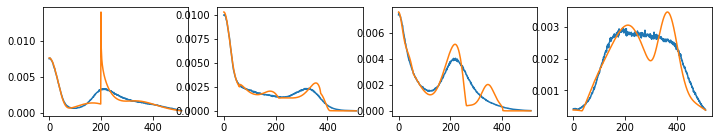

 epoch 73
   train loss: 0.000286568, mse: 0.000108682
   valid loss: 0.000289090, mse:0.000010409


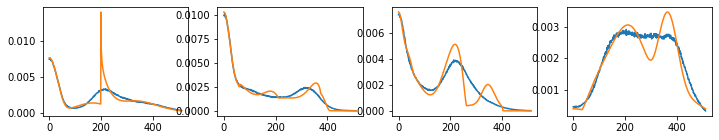

 epoch 74
   train loss: 0.000288151, mse: 0.000109013
   valid loss: 0.000297587, mse:0.000010490


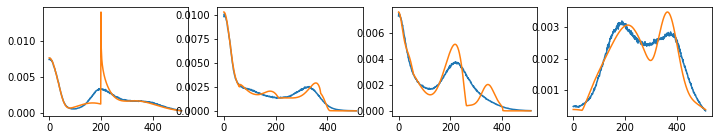

 epoch 75
   train loss: 0.000288105, mse: 0.000109148
   valid loss: 0.000291593, mse:0.000010443


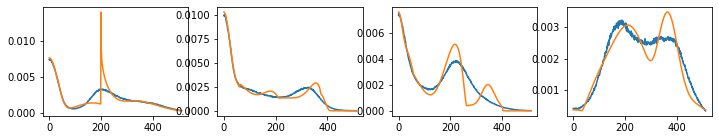

 epoch 76
   train loss: 0.000287211, mse: 0.000108849
   valid loss: 0.000290892, mse:0.000010469


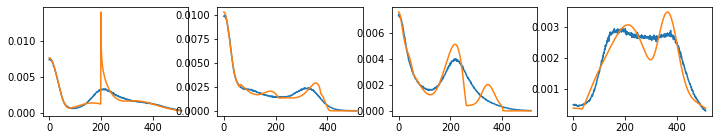

 epoch 77
   train loss: 0.000286315, mse: 0.000108532
   valid loss: 0.000296875, mse:0.000010522


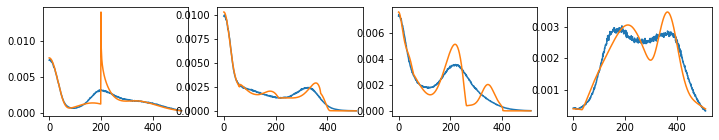

 epoch 78
   train loss: 0.000287792, mse: 0.000108967
   valid loss: 0.000305101, mse:0.000010808


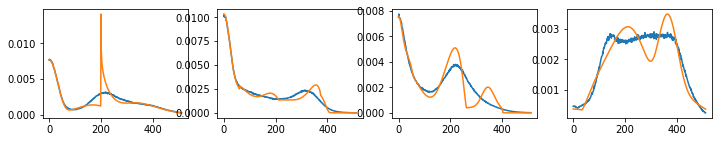

 epoch 79
   train loss: 0.000284672, mse: 0.000108108
   valid loss: 0.000286270, mse:0.000010348


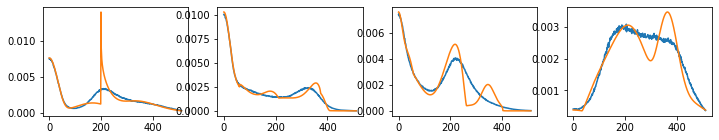

 epoch 80
   train loss: 0.000284829, mse: 0.000108114
   valid loss: 0.000290815, mse:0.000010522


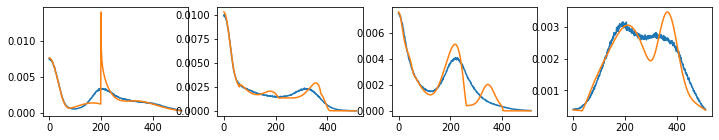

 epoch 81
   train loss: 0.000284863, mse: 0.000108017
   valid loss: 0.000288004, mse:0.000010355


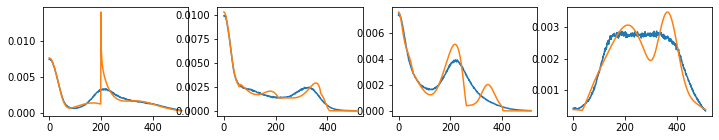

 epoch 82
   train loss: 0.000284863, mse: 0.000107891
   valid loss: 0.000303955, mse:0.000010705


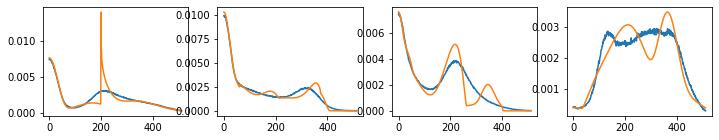

 epoch 83
   train loss: 0.000283131, mse: 0.000107484
   valid loss: 0.000286002, mse:0.000010300


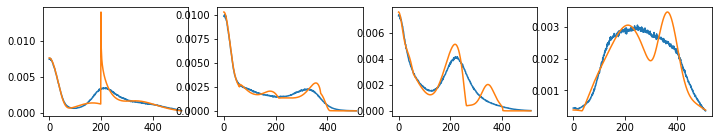

 epoch 84
   train loss: 0.000284944, mse: 0.000107947
   valid loss: 0.000293831, mse:0.000010585


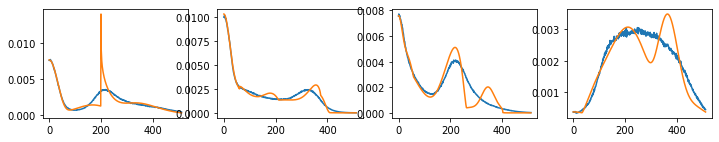

 epoch 85
   train loss: 0.000285279, mse: 0.000108086
   valid loss: 0.000291313, mse:0.000010520


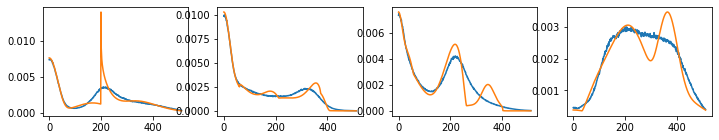

 epoch 86
   train loss: 0.000283755, mse: 0.000107554
   valid loss: 0.000287792, mse:0.000010322


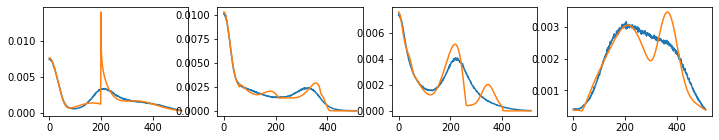

 epoch 87
   train loss: 0.000283839, mse: 0.000107647
   valid loss: 0.000300166, mse:0.000010482


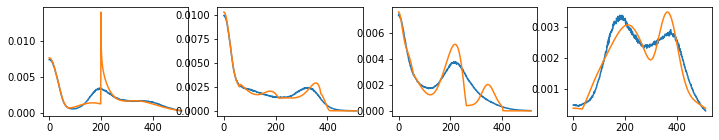

 epoch 88
   train loss: 0.000282357, mse: 0.000107076
   valid loss: 0.000297729, mse:0.000010795


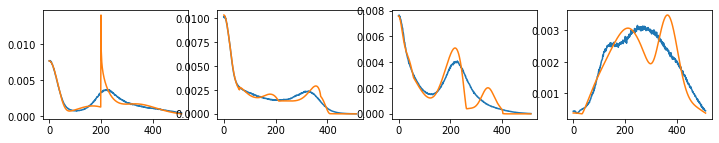

 epoch 89
   train loss: 0.000283049, mse: 0.000107275
   valid loss: 0.000292624, mse:0.000010351


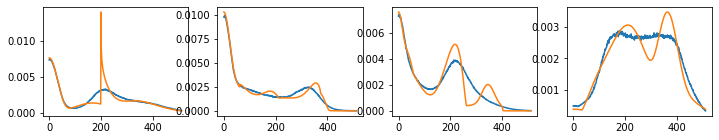

 epoch 90
   train loss: 0.000281642, mse: 0.000106879
   valid loss: 0.000285453, mse:0.000010257


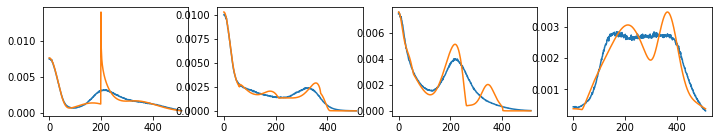

 epoch 91
   train loss: 0.000283951, mse: 0.000107599
   valid loss: 0.000288107, mse:0.000010327


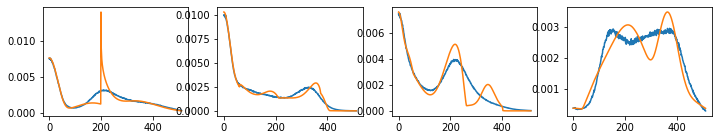

 epoch 92
   train loss: 0.000281783, mse: 0.000106894
   valid loss: 0.000285479, mse:0.000010266


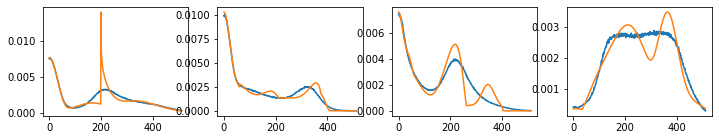

 epoch 93
   train loss: 0.000282616, mse: 0.000107099
   valid loss: 0.000290709, mse:0.000010490


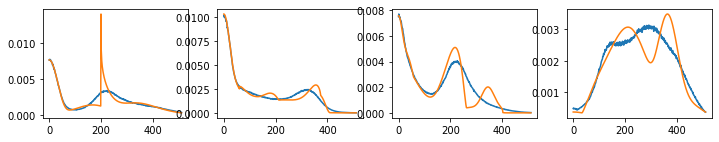

 epoch 94
   train loss: 0.000281356, mse: 0.000106661
   valid loss: 0.000287981, mse:0.000010262


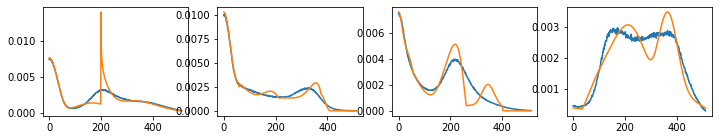

 epoch 95
   train loss: 0.000282596, mse: 0.000107034
   valid loss: 0.000289156, mse:0.000010354


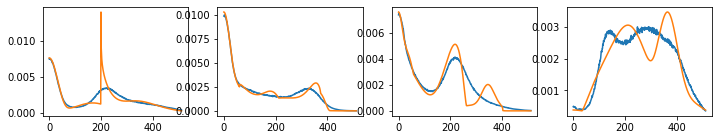

 epoch 96
   train loss: 0.000280632, mse: 0.000106414
   valid loss: 0.000286010, mse:0.000010260


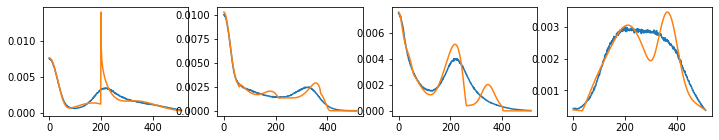

 epoch 97
   train loss: 0.000281313, mse: 0.000106397
   valid loss: 0.000282829, mse:0.000010257


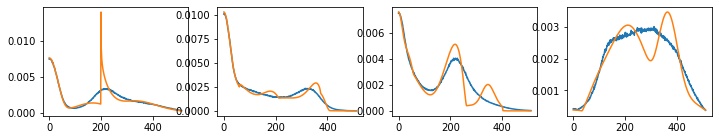

 epoch 98
   train loss: 0.000281136, mse: 0.000106480
   valid loss: 0.000287383, mse:0.000010295


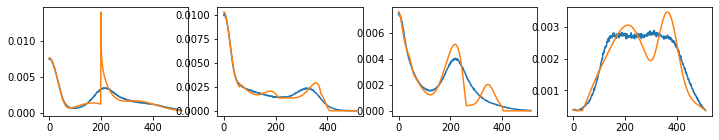

 epoch 99
   train loss: 0.000278692, mse: 0.000105778
   valid loss: 0.000286011, mse:0.000010342


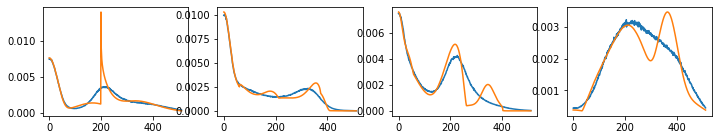

 epoch 100
   train loss: 0.000281049, mse: 0.000106377
   valid loss: 0.000287112, mse:0.000010400


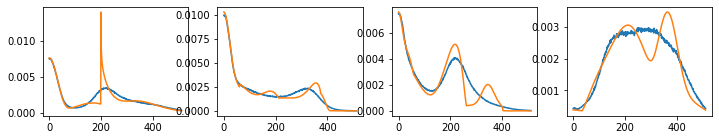

 epoch 101
   train loss: 0.000279415, mse: 0.000105767
   valid loss: 0.000287163, mse:0.000010265


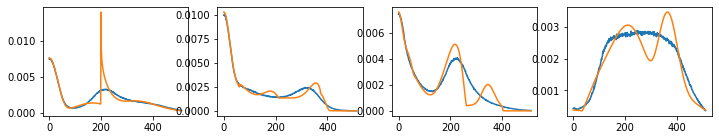

 epoch 102
   train loss: 0.000277032, mse: 0.000105265
   valid loss: 0.000308083, mse:0.000011051


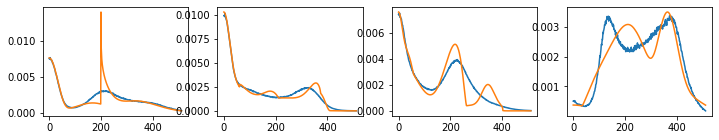

 epoch 103
   train loss: 0.000280949, mse: 0.000106423
   valid loss: 0.000306503, mse:0.000011088


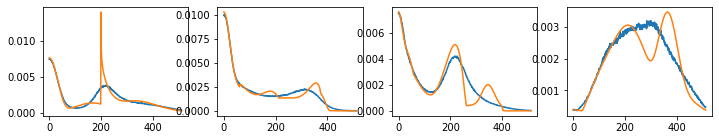

 epoch 104
   train loss: 0.000279059, mse: 0.000105871
   valid loss: 0.000294979, mse:0.000010474


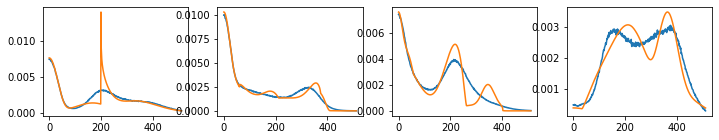

 epoch 105
   train loss: 0.000280646, mse: 0.000106177
   valid loss: 0.000287924, mse:0.000010349


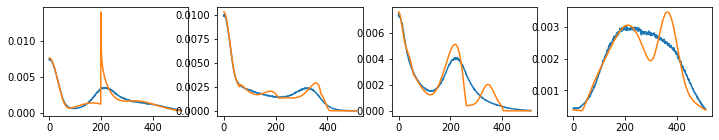

 epoch 106
   train loss: 0.000276948, mse: 0.000105146
   valid loss: 0.000298634, mse:0.000010625


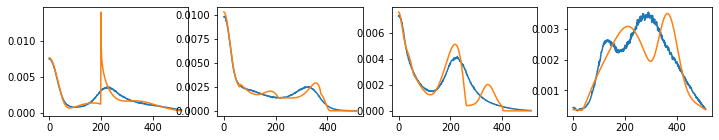

 epoch 107
   train loss: 0.000278380, mse: 0.000105526
   valid loss: 0.000298310, mse:0.000010554


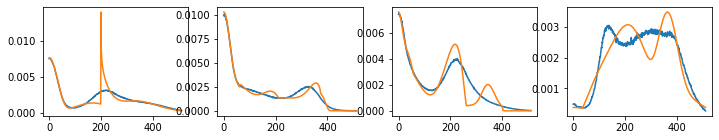

 epoch 108
   train loss: 0.000277979, mse: 0.000105314
   valid loss: 0.000279999, mse:0.000010086


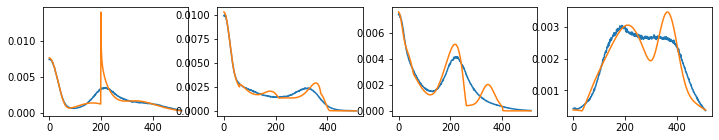

 epoch 109
   train loss: 0.000278047, mse: 0.000105384
   valid loss: 0.000307968, mse:0.000011068


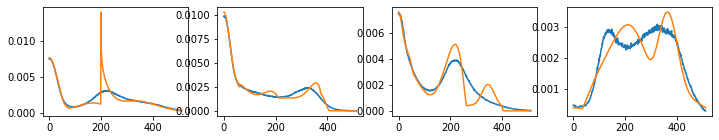

 epoch 110
   train loss: 0.000276636, mse: 0.000104955
   valid loss: 0.000283273, mse:0.000010125


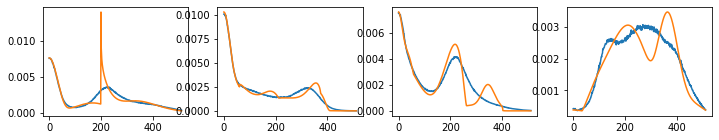

 epoch 111
   train loss: 0.000276759, mse: 0.000104998
   valid loss: 0.000289630, mse:0.000010221


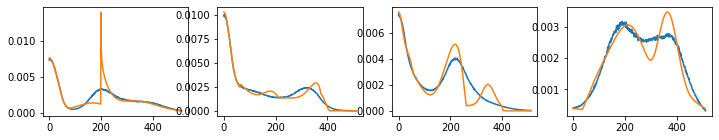

 epoch 112
   train loss: 0.000277927, mse: 0.000105391
   valid loss: 0.000289193, mse:0.000010226


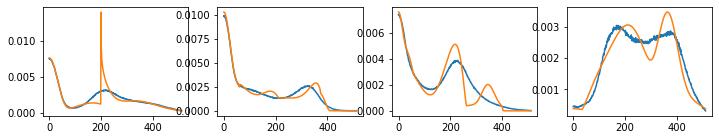

 epoch 113
   train loss: 0.000277377, mse: 0.000105140
   valid loss: 0.000277202, mse:0.000010026


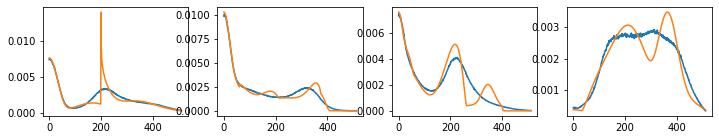

 epoch 114
   train loss: 0.000275615, mse: 0.000104366
   valid loss: 0.000286029, mse:0.000010135


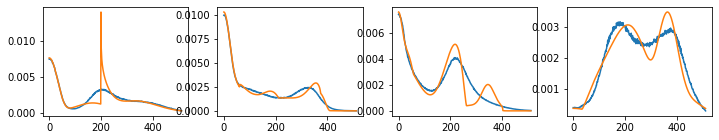

 epoch 115
   train loss: 0.000277170, mse: 0.000105091
   valid loss: 0.000286596, mse:0.000010321


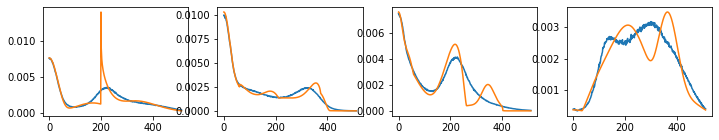

 epoch 116
   train loss: 0.000275176, mse: 0.000104464
   valid loss: 0.000278988, mse:0.000010010


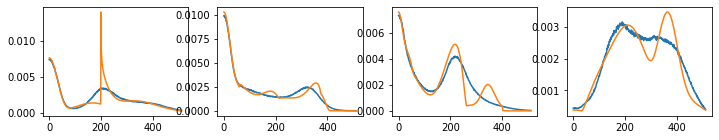

 epoch 117
   train loss: 0.000278275, mse: 0.000105177
   valid loss: 0.000300149, mse:0.000010618


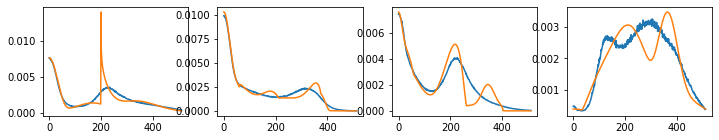

 epoch 118
   train loss: 0.000276038, mse: 0.000104596
   valid loss: 0.000285761, mse:0.000010159


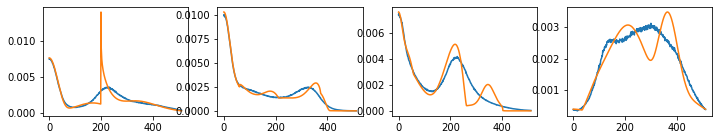

 epoch 119
   train loss: 0.000274133, mse: 0.000103980
   valid loss: 0.000284650, mse:0.000010094


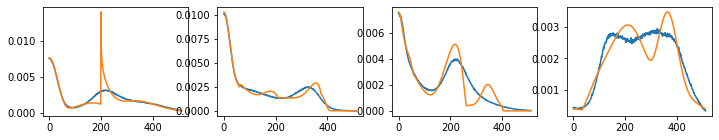

 epoch 120
   train loss: 0.000275065, mse: 0.000104305
   valid loss: 0.000288561, mse:0.000010420


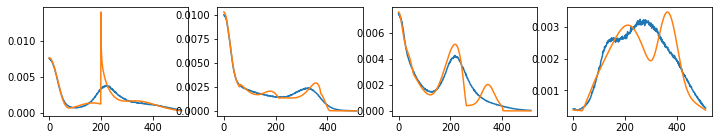

 epoch 121
   train loss: 0.000275176, mse: 0.000104225
   valid loss: 0.000279576, mse:0.000010077


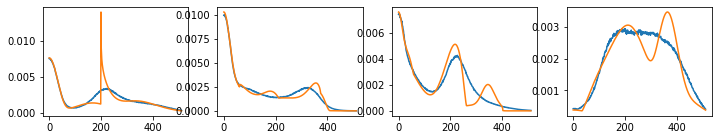

 epoch 122
   train loss: 0.000275739, mse: 0.000104383
   valid loss: 0.000286416, mse:0.000010354


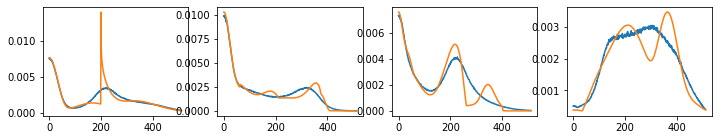

 epoch 123
   train loss: 0.000275508, mse: 0.000104379
   valid loss: 0.000304903, mse:0.000010870


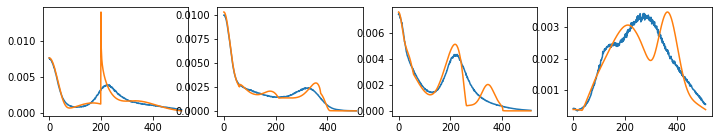

 epoch 124
   train loss: 0.000275876, mse: 0.000104470
   valid loss: 0.000284842, mse:0.000010142


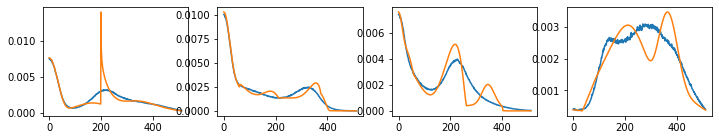

 epoch 125
   train loss: 0.000273533, mse: 0.000103702
   valid loss: 0.000281751, mse:0.000010064


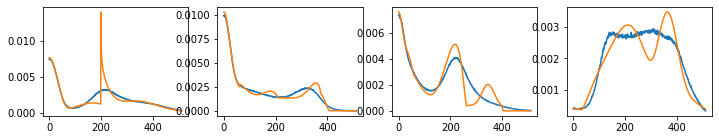

 epoch 126
   train loss: 0.000273169, mse: 0.000103344
   valid loss: 0.000294851, mse:0.000010456


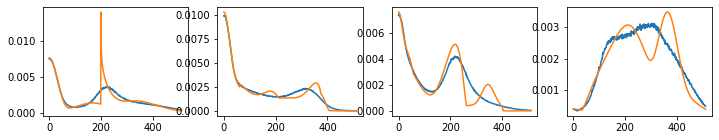

 epoch 127
   train loss: 0.000274427, mse: 0.000103969
   valid loss: 0.000289045, mse:0.000010397


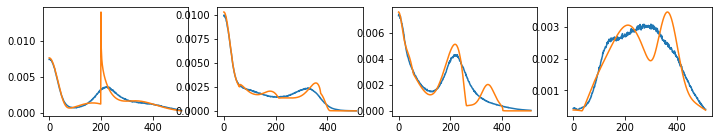

 epoch 128
   train loss: 0.000275122, mse: 0.000104212
   valid loss: 0.000287359, mse:0.000010245


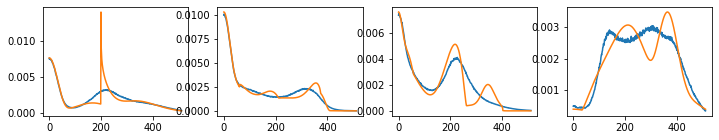

 epoch 129
   train loss: 0.000273616, mse: 0.000103683
   valid loss: 0.000280525, mse:0.000010151


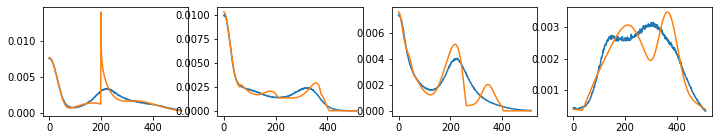

 epoch 130
   train loss: 0.000273572, mse: 0.000103807
   valid loss: 0.000278454, mse:0.000009955


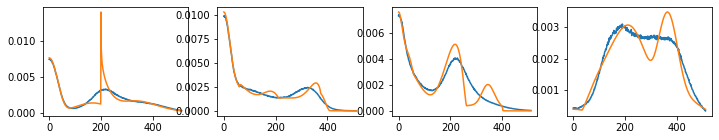

 epoch 131
   train loss: 0.000272549, mse: 0.000103348
   valid loss: 0.000279312, mse:0.000010125


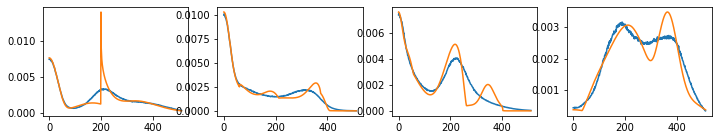

 epoch 132
   train loss: 0.000273118, mse: 0.000103458
   valid loss: 0.000278854, mse:0.000010094


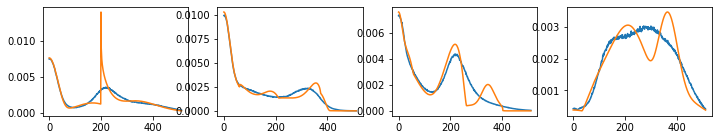

 epoch 133
   train loss: 0.000272660, mse: 0.000103319
   valid loss: 0.000280698, mse:0.000010093


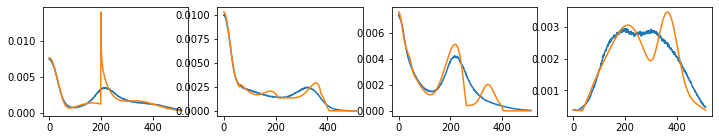

 epoch 134
   train loss: 0.000272136, mse: 0.000103246
   valid loss: 0.000286912, mse:0.000010315


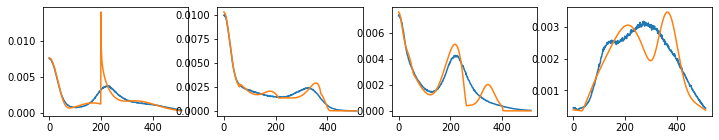

 epoch 135
   train loss: 0.000271935, mse: 0.000103037
   valid loss: 0.000280916, mse:0.000010047


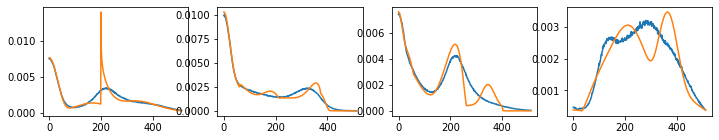

 epoch 136
   train loss: 0.000271535, mse: 0.000102894
   valid loss: 0.000279967, mse:0.000010006


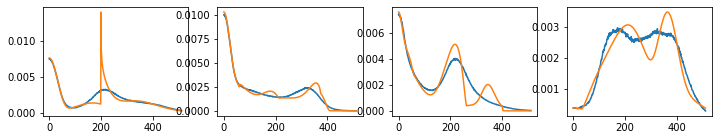

 epoch 137
   train loss: 0.000272133, mse: 0.000103144
   valid loss: 0.000302823, mse:0.000010784


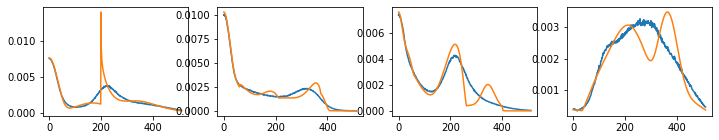

 epoch 138
   train loss: 0.000272521, mse: 0.000103190
   valid loss: 0.000278097, mse:0.000009926


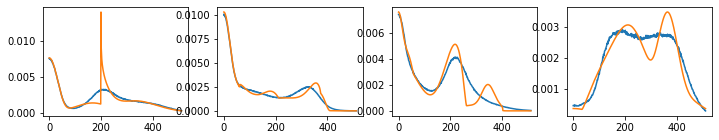

 epoch 139
   train loss: 0.000270561, mse: 0.000102636
   valid loss: 0.000279546, mse:0.000010048


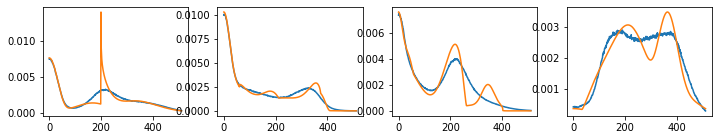

 epoch 140
   train loss: 0.000274612, mse: 0.000103917
   valid loss: 0.000289940, mse:0.000010377


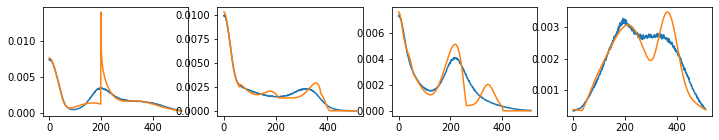

 epoch 141
   train loss: 0.000273287, mse: 0.000103542
   valid loss: 0.000281529, mse:0.000010057


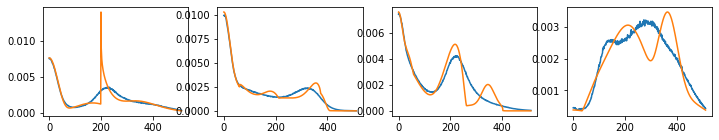

 epoch 142
   train loss: 0.000270962, mse: 0.000102693
   valid loss: 0.000282378, mse:0.000009980


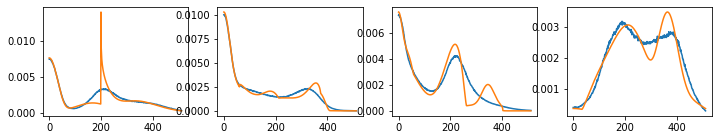

 epoch 143
   train loss: 0.000272335, mse: 0.000103047
   valid loss: 0.000287313, mse:0.000010092


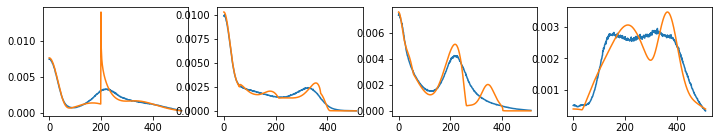

 epoch 144
   train loss: 0.000272185, mse: 0.000102921
   valid loss: 0.000281843, mse:0.000010124


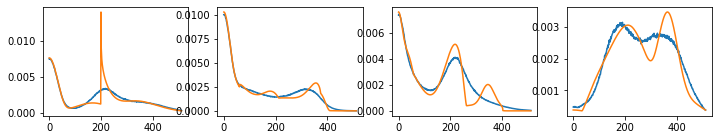

 epoch 145
   train loss: 0.000270994, mse: 0.000102721
   valid loss: 0.000292700, mse:0.000010306


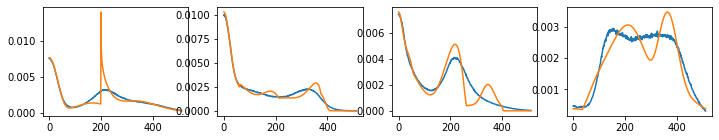

Epoch 00145: reducing learning rate of group 0 to 1.7280e-05.
 epoch 146
   train loss: 0.000257565, mse: 0.000099177
   valid loss: 0.000271419, mse:0.000009735


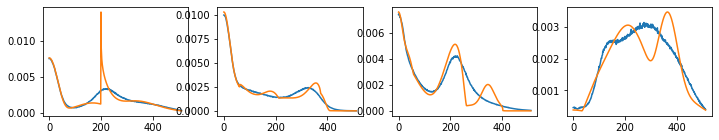

 epoch 147
   train loss: 0.000255871, mse: 0.000098512
   valid loss: 0.000269960, mse:0.000009681


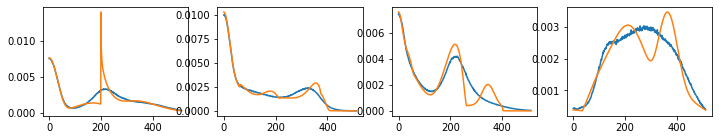

 epoch 148
   train loss: 0.000255263, mse: 0.000098203
   valid loss: 0.000269593, mse:0.000009656


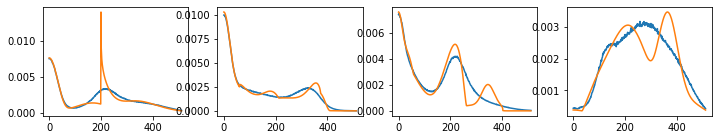

 epoch 149
   train loss: 0.000254808, mse: 0.000097974
   valid loss: 0.000275317, mse:0.000009774


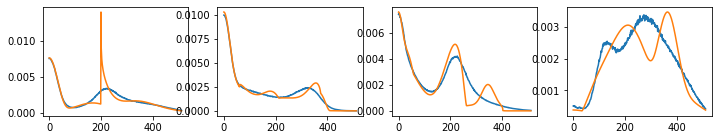

 epoch 150
   train loss: 0.000255692, mse: 0.000098194
   valid loss: 0.000274923, mse:0.000009792


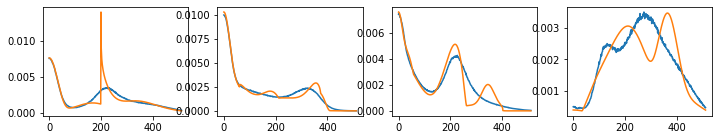

 epoch 151
   train loss: 0.000254378, mse: 0.000097677
   valid loss: 0.000268892, mse:0.000009625


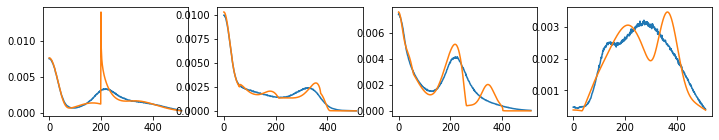

 epoch 152
   train loss: 0.000255430, mse: 0.000098041
   valid loss: 0.000269625, mse:0.000009617


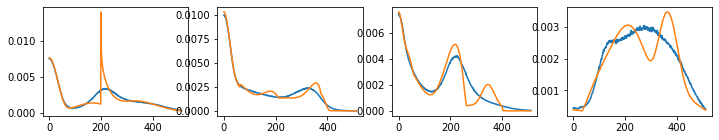

 epoch 153
   train loss: 0.000254451, mse: 0.000097697
   valid loss: 0.000271926, mse:0.000009704


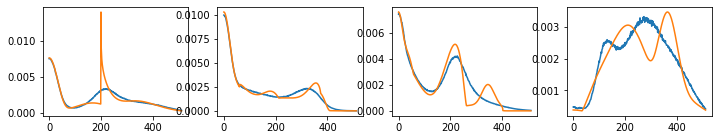

 epoch 154
   train loss: 0.000254704, mse: 0.000097760
   valid loss: 0.000269661, mse:0.000009651


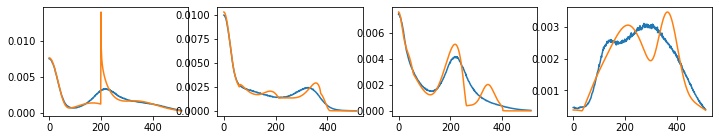

 epoch 155
   train loss: 0.000254133, mse: 0.000097612
   valid loss: 0.000269379, mse:0.000009639


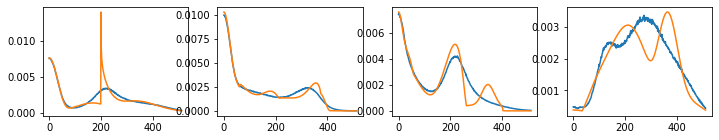

 epoch 156
   train loss: 0.000255476, mse: 0.000097885
   valid loss: 0.000270164, mse:0.000009658


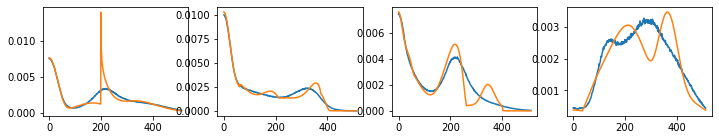

 epoch 157
   train loss: 0.000254187, mse: 0.000097650
   valid loss: 0.000270053, mse:0.000009612


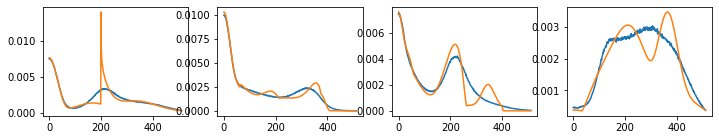

 epoch 158
   train loss: 0.000253867, mse: 0.000097515
   valid loss: 0.000271281, mse:0.000009647


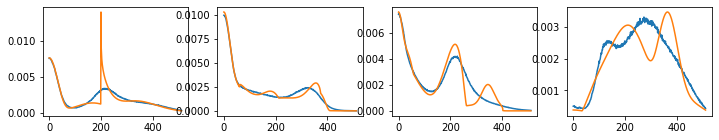

 epoch 159
   train loss: 0.000253010, mse: 0.000097151
   valid loss: 0.000268918, mse:0.000009602


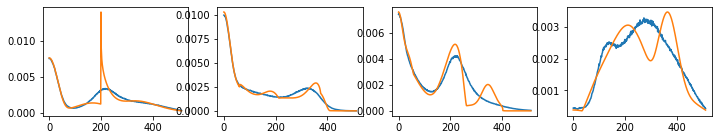

 epoch 160
   train loss: 0.000254887, mse: 0.000097707
   valid loss: 0.000270231, mse:0.000009632


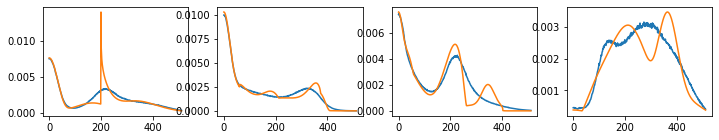

 epoch 161
   train loss: 0.000253612, mse: 0.000097334
   valid loss: 0.000269747, mse:0.000009621


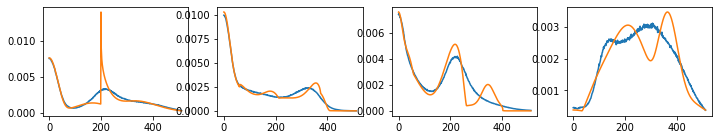

 epoch 162
   train loss: 0.000253301, mse: 0.000097258
   valid loss: 0.000269215, mse:0.000009605


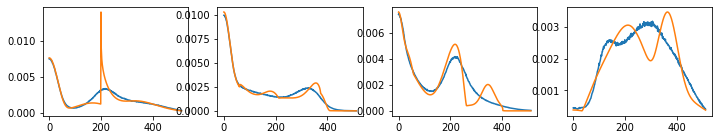

 epoch 163
   train loss: 0.000253437, mse: 0.000097336
   valid loss: 0.000267223, mse:0.000009558


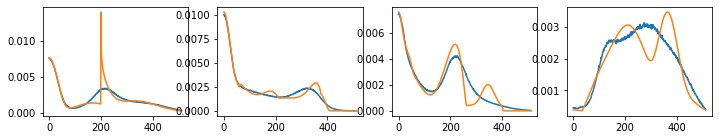

 epoch 164
   train loss: 0.000254000, mse: 0.000097376
   valid loss: 0.000268670, mse:0.000009642


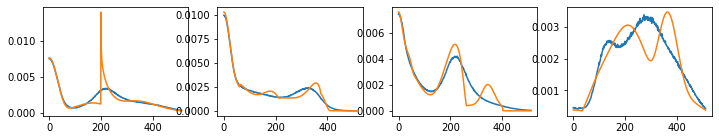

 epoch 165
   train loss: 0.000253762, mse: 0.000097353
   valid loss: 0.000270302, mse:0.000009628


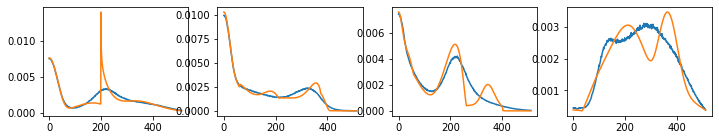

Epoch 00165: reducing learning rate of group 0 to 3.7325e-06.
 epoch 166
   train loss: 0.000250041, mse: 0.000096505
   valid loss: 0.000267609, mse:0.000009544


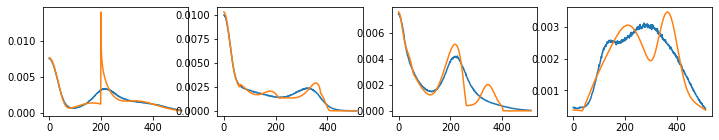

 epoch 167
   train loss: 0.000249791, mse: 0.000096409
   valid loss: 0.000268569, mse:0.000009579


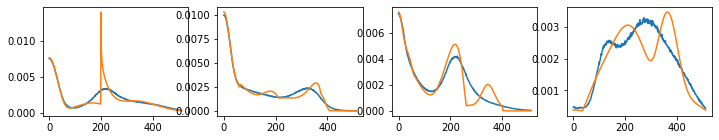

 epoch 168
   train loss: 0.000249739, mse: 0.000096341
   valid loss: 0.000268459, mse:0.000009593


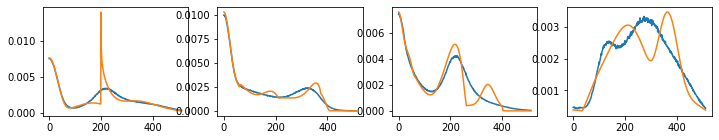

 epoch 169
   train loss: 0.000249681, mse: 0.000096362
   valid loss: 0.000269127, mse:0.000009590


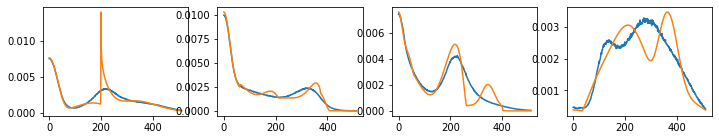

 epoch 170
   train loss: 0.000249787, mse: 0.000096364
   valid loss: 0.000269651, mse:0.000009606


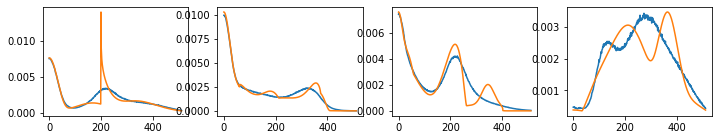

 epoch 171
   train loss: 0.000249640, mse: 0.000096292
   valid loss: 0.000267524, mse:0.000009545


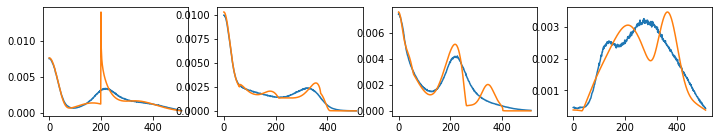

 epoch 172
   train loss: 0.000249463, mse: 0.000096244
   valid loss: 0.000270698, mse:0.000009650


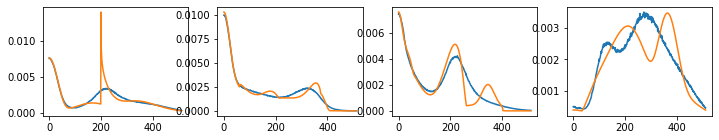

 epoch 173
   train loss: 0.000249523, mse: 0.000096267
   valid loss: 0.000268833, mse:0.000009580


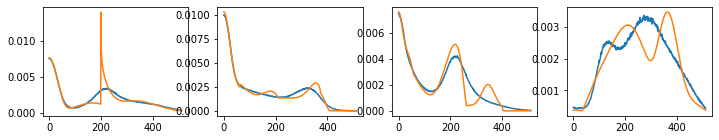

 epoch 174
   train loss: 0.000249657, mse: 0.000096217
   valid loss: 0.000268184, mse:0.000009562


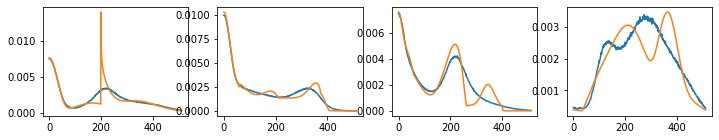

 epoch 175
   train loss: 0.000249601, mse: 0.000096143
   valid loss: 0.000268335, mse:0.000009575


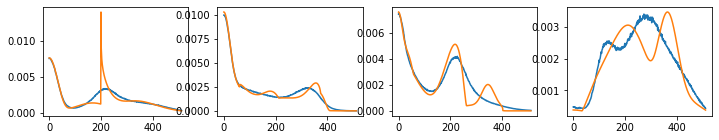

 epoch 176
   train loss: 0.000249547, mse: 0.000096193
   valid loss: 0.000270169, mse:0.000009606


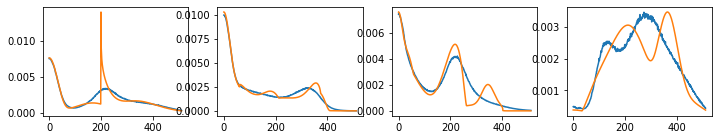

 epoch 177
   train loss: 0.000249333, mse: 0.000096154
   valid loss: 0.000268191, mse:0.000009562


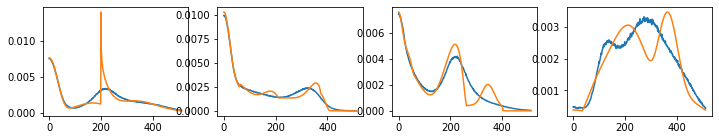

 epoch 178
   train loss: 0.000249353, mse: 0.000096165
   valid loss: 0.000269549, mse:0.000009574


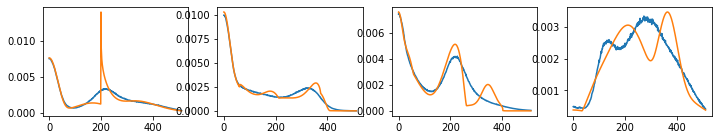

 epoch 179
   train loss: 0.000249346, mse: 0.000096135
   valid loss: 0.000269652, mse:0.000009616


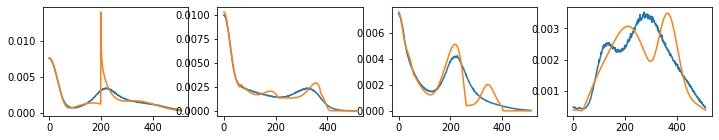

 epoch 180
   train loss: 0.000249234, mse: 0.000096109
   valid loss: 0.000267746, mse:0.000009547


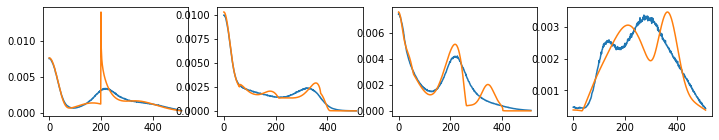

 epoch 181
   train loss: 0.000249183, mse: 0.000096088
   valid loss: 0.000267143, mse:0.000009533


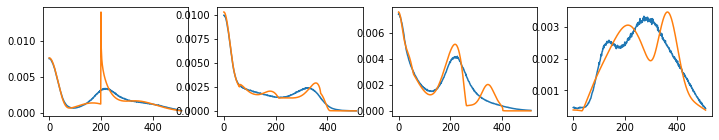

 epoch 182
   train loss: 0.000249204, mse: 0.000096103
   valid loss: 0.000268523, mse:0.000009558


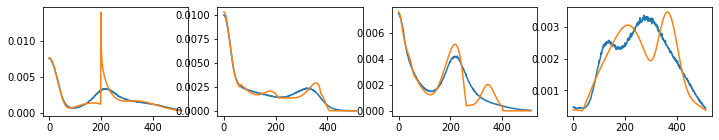

 epoch 183
   train loss: 0.000249393, mse: 0.000096135
   valid loss: 0.000267201, mse:0.000009538


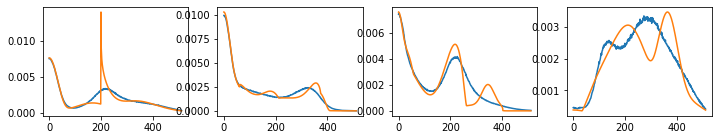

 epoch 184
   train loss: 0.000248906, mse: 0.000096004
   valid loss: 0.000267531, mse:0.000009544


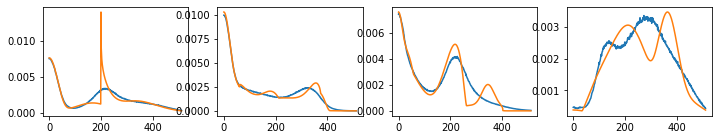

 epoch 185
   train loss: 0.000249194, mse: 0.000096068
   valid loss: 0.000267957, mse:0.000009544


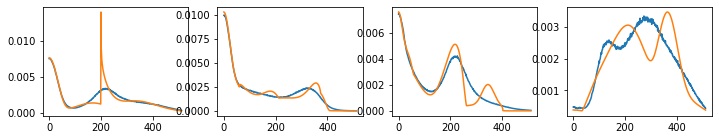

 epoch 186
   train loss: 0.000248807, mse: 0.000095903
   valid loss: 0.000269285, mse:0.000009587


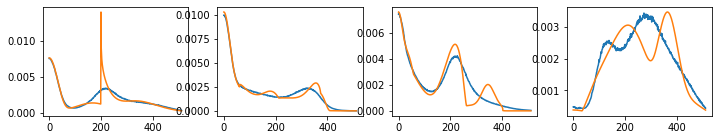

 epoch 187
   train loss: 0.000249025, mse: 0.000096033
   valid loss: 0.000267467, mse:0.000009539


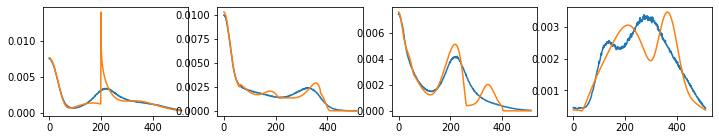

 epoch 188
   train loss: 0.000249017, mse: 0.000095993
   valid loss: 0.000266976, mse:0.000009510


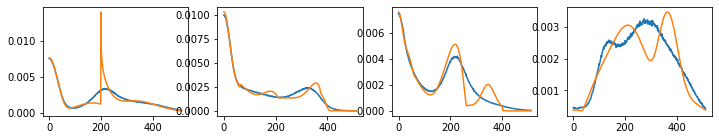

 epoch 189
   train loss: 0.000248778, mse: 0.000095897
   valid loss: 0.000268331, mse:0.000009565


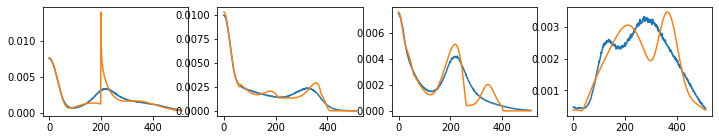

 epoch 190
   train loss: 0.000248903, mse: 0.000095962
   valid loss: 0.000268504, mse:0.000009572


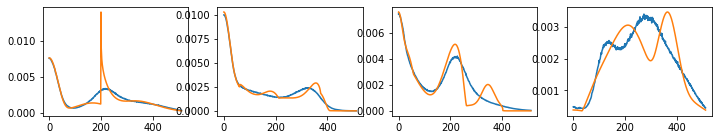

 epoch 191
   train loss: 0.000248679, mse: 0.000095848
   valid loss: 0.000268481, mse:0.000009581


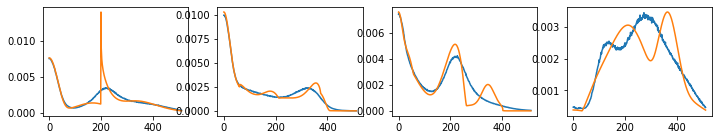

 epoch 192
   train loss: 0.000248529, mse: 0.000095804
   valid loss: 0.000269052, mse:0.000009561


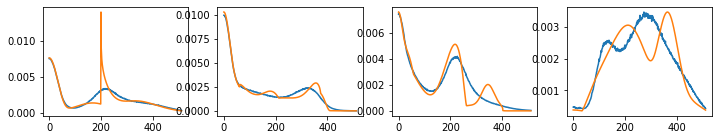

 epoch 193
   train loss: 0.000248712, mse: 0.000095837
   valid loss: 0.000269777, mse:0.000009597


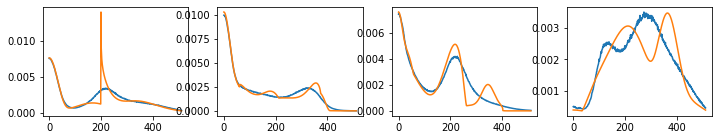

 epoch 194
   train loss: 0.000248665, mse: 0.000095891
   valid loss: 0.000266911, mse:0.000009511


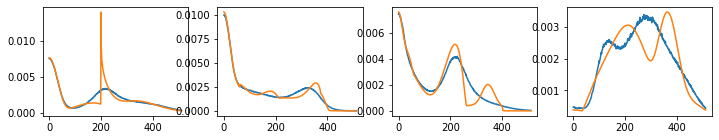

 epoch 195
   train loss: 0.000248477, mse: 0.000095804
   valid loss: 0.000268920, mse:0.000009564


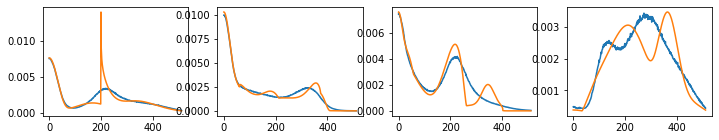

 epoch 196
   train loss: 0.000248416, mse: 0.000095815
   valid loss: 0.000267748, mse:0.000009545


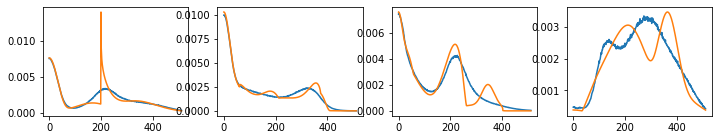

 epoch 197
   train loss: 0.000248516, mse: 0.000095796
   valid loss: 0.000271763, mse:0.000009664


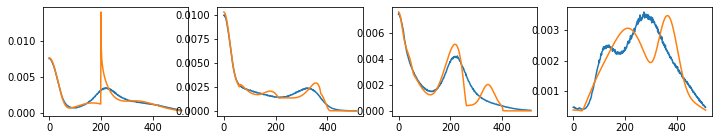

 epoch 198
   train loss: 0.000248349, mse: 0.000095696
   valid loss: 0.000265712, mse:0.000009487


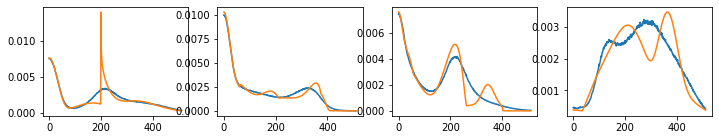

 epoch 199
   train loss: 0.000248650, mse: 0.000095842
   valid loss: 0.000266093, mse:0.000009499


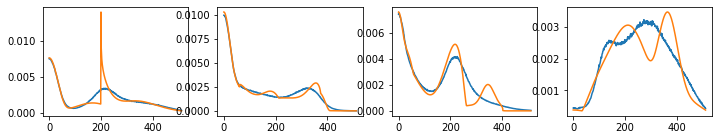

 epoch 200
   train loss: 0.000248321, mse: 0.000095716
   valid loss: 0.000265517, mse:0.000009479


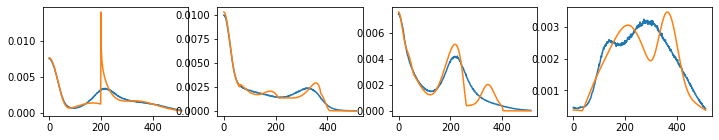

In [5]:
n_epochs = 200
early_stop_count = 40
best_valid_loss = TORCH_MAX
for epoch in range(1, n_epochs+1):
    print(f' epoch {epoch}')
    avg_train_loss = 0
    avg_train_mse = 0

    model.train()
    for batch_number, (inputs, targets) in enumerate(train_loader):
        
        # learning rate warmup
        if epoch == 1: 
            tmp_lr = (batch_number+1)*lr/len(train_loader)
            for g in optimizer.param_groups:
                g['lr'] = tmp_lr

        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        mse = mse_function(outputs, targets)
        avg_train_mse += mse.item()
        avg_train_loss += loss.item()
    
    avg_train_loss = avg_train_loss/len(train_loader)
    print(f'   train loss: {avg_train_loss:.9f}, mse: {avg_train_mse:.9f}')

    model.eval()
    avg_valid_loss = 0
    avg_valid_mse = 0
    for batch_number, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        mse = mse_function(outputs, targets)
        avg_valid_loss += loss.item()
        avg_valid_mse += mse.item()

    avg_valid_loss = avg_valid_loss/len(valid_loader)
    print(f'   valid loss: {avg_valid_loss:.9f}, mse:{avg_valid_mse:.9f}')
    
    # plot a few validation spectra
    offset = 10
    n_plots = 4
    _, ax = plt.subplots(1,n_plots, figsize=(12,2))
    for i in range(n_plots):
        ax[i].plot(outputs[i+offset].detach().numpy())
        ax[i].plot(targets[i+offset].detach().numpy())
    plt.pause(0.001)
    
    scheduler.step(avg_train_loss)
    early_stop_count -= 1
    if avg_valid_loss < best_valid_loss:
        early_stop_count = 40
        best_valid_loss = avg_valid_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        
    if early_stop_count == 0:
        print('early stopping limit reached!!')
        print(f'best epoch was {best_epoch}')
        break

## Saving the best model

In [6]:
torch.save(best_model.state_dict(), "best_model.pt")

## Loading the model

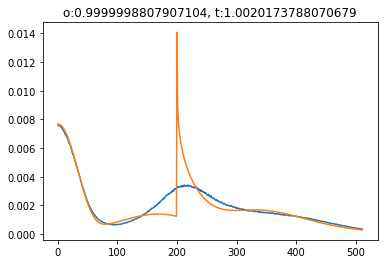

In [20]:
loaded_model = MLP().to(device)
loaded_model.load_state_dict(torch.load("best_model.pt", map_location=device))

outputs = loaded_model(inputs)
i = np.random.randint(0,64)
plt.plot(outputs[i].detach().numpy())
plt.plot(targets[i].detach().numpy())
plt.title(f"o:{outputs[0].sum().detach().numpy()}, t:{targets[0].sum().detach().numpy()}")
plt.show()